#Import and Define
Project 2: Time Series Forecasting using NN, LSTM, and CNN

Authors: Jason Phillips and Peeja

In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

In [37]:
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
#Import and print out the current version of packages.
%load_ext tensorboard

import tensorflow as tf
import tf_explain
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn as sk
import pandas as pd
import shutil
import os
import imblearn
import io
import requests
import datetime

from scipy.stats import zscore
from collections.abc import Sequence
from collections import Counter
from numpy import where
from sklearn.datasets import make_classification
from matplotlib import pyplot
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,LSTM

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

print('Python {}'.format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print('Tensor Flow {}'.format(tf.__version__))
print('Keras {}'.format(tf.keras.__version__))
print('Imblearn {}'.format(imblearn.__version__))

#Remove any files in the log folder for tensorboard
!rm -rf "/content/drive/MyDrive/Colab Notebooks/logs/"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Python 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
Pandas 1.3.5
Numpy 1.22.4
Scikit-Learn 1.2.1

Tensor Flow 2.11.0
Keras 2.11.0
Imblearn 0.8.1


In [39]:
#Define the log folder for tensorboard
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Data Preprocessing
Import dataset and preprocess it.

In [40]:
#Create the dataframe and convert empty values to NA
df = pd.read_csv('https://raw.githubusercontent.com/JasonTPhillipsJr/CSC215/main/TSLA.csv', na_values=['NA', '?'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3186,2023-02-24,196.330002,197.669998,192.800003,196.880005,196.880005,142228100
3187,2023-02-27,202.029999,209.419998,201.259995,207.630005,207.630005,161028300
3188,2023-02-28,210.589996,211.229996,203.750000,205.710007,205.710007,153144900
3189,2023-03-01,206.210007,207.199997,198.520004,202.770004,202.770004,156852800


In [41]:
#Check if any values are empty or null
df[df.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


In [42]:
#Display data types for each column
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [43]:
#Show some statistics for each column.
data = {'Mean': df.mean(),
        'Max': df.max(),
        'Min': df.min(),
        'Variaence': df.var(),
        'STD': df.std()}

dataframe = pd.DataFrame(data)
dataframe

<ipython-input-43-0e371d19d6b4>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = {'Mean': df.mean(),
<ipython-input-43-0e371d19d6b4>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'Variaence': df.var(),
<ipython-input-43-0e371d19d6b4>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'STD': df.std()}


,Mean,Max,Min,Variaence,STD
Adj Close,6.020587e+01,409.970001,1.053333,9.175041e+03,9.578644e+01
Close,6.020587e+01,409.970001,1.053333,9.175041e+03,9.578644e+01
Date,NaN,2023-03-02,2010-06-29,NaN,NaN
High,6.160542e+01,414.496674,1.108667,9.626803e+03,9.811627e+01
Low,5.874202e+01,405.666656,0.998667,8.724170e+03,9.340326e+01
Open,6.023675e+01,411.470001,1.076,9.195453e+03,9.589293e+01
Volume,9.485638e+07,914082000,1777500,6.723681e+15,8.199805e+07


In [44]:
#Drop columns that aren't needed
df = df.drop(['Date', 'Adj Close'], axis=1)
df

,Open,High,Low,Close,Volume
0,1.266667,1.666667,1.169333,1.592667,281494500
1,1.719333,2.028000,1.553333,1.588667,257806500
2,1.666667,1.728000,1.351333,1.464000,123282000
3,1.533333,1.540000,1.247333,1.280000,77097000
4,1.333333,1.333333,1.055333,1.074000,103003500
...,...,...,...,...,...
3186,196.330002,197.669998,192.800003,196.880005,142228100
3187,202.029999,209.419998,201.259995,207.630005,161028300
3188,210.589996,211.229996,203.750000,205.710007,153144900
3189,206.210007,207.199997,198.520004,202.770004,156852800


In [45]:
#Create a copy of the Close column to use for the output feature.
df['Close_Output'] = df['Close']
df


,Open,High,Low,Close,Volume,Close_Output
0,1.266667,1.666667,1.169333,1.592667,281494500,1.592667
1,1.719333,2.028000,1.553333,1.588667,257806500,1.588667
2,1.666667,1.728000,1.351333,1.464000,123282000,1.464000
3,1.533333,1.540000,1.247333,1.280000,77097000,1.280000
4,1.333333,1.333333,1.055333,1.074000,103003500,1.074000
...,...,...,...,...,...,...
3186,196.330002,197.669998,192.800003,196.880005,142228100,196.880005
3187,202.029999,209.419998,201.259995,207.630005,161028300,207.630005
3188,210.589996,211.229996,203.750000,205.710007,153144900,205.710007
3189,206.210007,207.199997,198.520004,202.770004,156852800,202.770004


In [46]:
#Normalize the Numeric Data
df['Open'] = zscore(df['Open'])
df['High'] = zscore(df['High'])
df['Low'] = zscore(df['Low'])
df['Close'] = zscore(df['Close'])
df['Volume'] = zscore(df['Volume'])

#Never normalize the output feature when traaining any regression models, else RMSE will also be normalized
#df['Close_Output'] = zscore(df['Close_Output'])
df

,Open,High,Low,Close,Volume,Close_Output
0,-0.615054,-0.610991,-0.616485,-0.612011,2.276485,1.592667
1,-0.610333,-0.607308,-0.612373,-0.612053,1.987555,1.588667
2,-0.610882,-0.610366,-0.614536,-0.613355,0.346716,1.464000
3,-0.612273,-0.612282,-0.615650,-0.615276,-0.216617,1.280000
4,-0.614359,-0.614389,-0.617706,-0.617427,0.099373,1.074000
...,...,...,...,...,...,...
3186,1.419443,1.386986,1.435485,1.427087,0.577808,196.880005
3187,1.478894,1.506761,1.526074,1.539333,0.807120,207.630005
3188,1.568174,1.525211,1.552737,1.519285,0.710964,205.710007
3189,1.522491,1.484131,1.496735,1.488587,0.756190,202.770004


#Splitting the Data
Create test and training splits with a 30/70 split

Now we have two Dataframes: df and df_y for input/output.
reshape df to be a sequence of 35 inputs per output.

In [47]:
from sklearn.externals._packaging.version import Tuple
#Setup our Input and ouput features to be of the correct shape.
#We want the first seven rows and 5 columns per prediction. 35 values total
#Since we have 3191 Rows of data. rows/7 = 455 rows as input vectors with 35 values in each vector.
SEQUENCE_SIZE = 7
def create_dataset(time_step, data):
  x = []  #input
  y = []  #output
  for i in range(len(data)-time_step-1):
    x_temp = data.loc[i:i+time_step-1,["Open","High","Low","Close","Volume"]]
    x.append(x_temp)
    y_temp = data.loc[i+time_step,["Close_Output"]]   #Note, we take the (i+1)th value instead of the ith because we are looking at the close for the next day after the time_step.
    y.append(y_temp)
  return x,y

x,y = create_dataset(SEQUENCE_SIZE, df)

In [48]:
#Ensure x is of the correct shape
len(x)

3183

In [49]:
#Ensure we have the right size
print(x[1])
print(len(x[1]))
print(len(y))
print(y[1])

       Open      High       Low     Close    Volume
1 -0.610333 -0.607308 -0.612373 -0.612053  1.987555
2 -0.610882 -0.610366 -0.614536 -0.613355  0.346716
3 -0.612273 -0.612282 -0.615650 -0.615276 -0.216617
4 -0.614359 -0.614389 -0.617706 -0.617427  0.099373
5 -0.616862 -0.616679 -0.618312 -0.617643  0.109399
6 -0.617043 -0.616074 -0.617891 -0.616487  0.253883
7 -0.616041 -0.615816 -0.617192 -0.616529 -0.415897
7
3183
Close_Output    1.136667
Name: 8, dtype: float64


In [50]:
#Convert x and y to numpy arrays for tensorflow
#Reshape the arrays to be of the correct size for problem 1.
num_rows = len(x)
x = np.array(x)
y = np.array(y)

In [51]:
x_NN = x.reshape(num_rows,35)
y_NN = y.reshape(num_rows,1)

In [52]:
"""
#Choose only the 8th input from the output column. After 7 days make a prediction.
y = []
i = 1
counter = 0
while i in range(len(df_y)):
  #print (i)
  
  if(counter == 7):
    #print("i is" + str(i))
    #print("df at i is" + str(df_y[i]))
    counter = 0
    y.append(df_y[i])
  
  counter += 1
  i+=1

y = np.array(y)
y = y.reshape(455,1)
#print(df_y.shape)
print(y.shape)
print(y)

"""   

'\n#Choose only the 8th input from the output column. After 7 days make a prediction.\ny = []\ni = 1\ncounter = 0\nwhile i in range(len(df_y)):\n  #print (i)\n  \n  if(counter == 7):\n    #print("i is" + str(i))\n    #print("df at i is" + str(df_y[i]))\n    counter = 0\n    y.append(df_y[i])\n  \n  counter += 1\n  i+=1\n\ny = np.array(y)\ny = y.reshape(455,1)\n#print(df_y.shape)\nprint(y.shape)\nprint(y)\n\n'

In [53]:
"""
x = []
i = 0
df = df.to_numpy()
counter = 0
while i in range(len(df)):
  #print (i)
 
  if(counter == 7):
    #print("i is" + str(i))
    #print("df at i is" + str(df[i]))
    counter = 0
    window = df[i:(i+7)]
    #window = [[x] for x in window]
    #print("{} - {}".format(window,after_window))
    x.append(window)
  
  counter += 1
  i+=1


x = np.array(x)
#print(df.shape)
x = x.reshape(455,35)
print(x.shape)
print(x)
"""

'\nx = []\ni = 0\ndf = df.to_numpy()\ncounter = 0\nwhile i in range(len(df)):\n  #print (i)\n \n  if(counter == 7):\n    #print("i is" + str(i))\n    #print("df at i is" + str(df[i]))\n    counter = 0\n    window = df[i:(i+7)]\n    #window = [[x] for x in window]\n    #print("{} - {}".format(window,after_window))\n    x.append(window)\n  \n  counter += 1\n  i+=1\n\n\nx = np.array(x)\n#print(df.shape)\nx = x.reshape(455,35)\nprint(x.shape)\nprint(x)\n'

In [54]:
"""
#Remove the last few rows so that we can have an equal amount of weeks: 7 * 455 = 3185. Add 1 for the last output column value
total_rows = 3186
df = df[0:total_rows]
df_y = df_y[0:total_rows]

print(df.shape)
print(df_y.shape)
"""

'\n#Remove the last few rows so that we can have an equal amount of weeks: 7 * 455 = 3185. Add 1 for the last output column value\ntotal_rows = 3186\ndf = df[0:total_rows]\ndf_y = df_y[0:total_rows]\n\nprint(df.shape)\nprint(df_y.shape)\n'

In [55]:
#Create the x(inputs) and y(outputs)

#Close_Output = df["Close_Output"]
#x,y = to_xy(df,"Close_Output")

#Split the train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_NN, y_NN, test_size=0.30, random_state=42)


In [56]:
#ratio = 0.70
 
#total_rows = df.shape[0]
#train_size = int(total_rows*ratio)
 
# Split data into test and train
#df_train = df[0:train_size]
#df_test = df[train_size:]

#spots_train = df_train["Close_Output"].tolist()
#spots_test = df_test["Close_Output"].tolist()

#print("Training set has {} records.".format(len(df_train)))
#print("Test set has {} records.".format(len(df_test)))
#print("Shape of df_train: {}".format(df_train.shape))
#print("Shape of df_test: {}".format(df_test.shape))

In [57]:
"""
df_train = df.to_numpy()
df_test = df.to_numpy()
"""

'\ndf_train = df.to_numpy()\ndf_test = df.to_numpy()\n'

In [58]:
"""
df_train.flatten()
df_test.flatten()
"""

'\ndf_train.flatten()\ndf_test.flatten()\n'

In [59]:
"""
SEQUENCE_SIZE = 35
x_train,y_train = to_sequences(SEQUENCE_SIZE,df_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,df_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))
"""

'\nSEQUENCE_SIZE = 35\nx_train,y_train = to_sequences(SEQUENCE_SIZE,df_train)\nx_test,y_test = to_sequences(SEQUENCE_SIZE,df_test)\n\nprint("Shape of x_train: {}".format(x_train.shape))\nprint("Shape of x_test: {}".format(x_test.shape))\nprint("Shape of y_train: {}".format(y_train.shape))\nprint("Shape of y_test: {}".format(y_test.shape))\n'

In [60]:
#Visualize the shape for each array
print("x shape: " + str(x.shape))
print("y shape: " + str(y.shape))
print()
print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))
print()
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

x shape: (3183, 7, 5)
y shape: (3183, 1)

x_train shape: (2228, 35)
x_test shape: (955, 35)

y_train shape: (2228, 1)
y_test shape: (955, 1)


#Fully Connected Neural Network Model
Use sequential model to process input vectors of 35 features per each 1 output



Epoch 1/500
70/70 - 2s - loss: 11302.7979 - accuracy: 0.0000e+00 - val_loss: 10426.1094 - val_accuracy: 0.0000e+00 - 2s/epoch - 27ms/step
Epoch 2/500
70/70 - 0s - loss: 5508.1123 - accuracy: 0.0000e+00 - val_loss: 1666.5608 - val_accuracy: 0.0000e+00 - 441ms/epoch - 6ms/step
Epoch 3/500
70/70 - 0s - loss: 381.0534 - accuracy: 0.0000e+00 - val_loss: 193.8696 - val_accuracy: 0.0000e+00 - 435ms/epoch - 6ms/step
Epoch 4/500
70/70 - 0s - loss: 183.3692 - accuracy: 0.0000e+00 - val_loss: 187.5800 - val_accuracy: 0.0000e+00 - 458ms/epoch - 7ms/step
Epoch 5/500
70/70 - 0s - loss: 176.2110 - accuracy: 0.0000e+00 - val_loss: 181.3109 - val_accuracy: 0.0000e+00 - 335ms/epoch - 5ms/step
Epoch 6/500
70/70 - 0s - loss: 170.6623 - accuracy: 0.0000e+00 - val_loss: 174.8448 - val_accuracy: 0.0000e+00 - 291ms/epoch - 4ms/step
Epoch 7/500
70/70 - 0s - loss: 163.9666 - accuracy: 0.0000e+00 - val_loss: 169.3730 - val_accuracy: 0.0000e+00 - 305ms/epoch - 4ms/step
Epoch 8/500
70/70 - 0s - loss: 158.7124 - ac

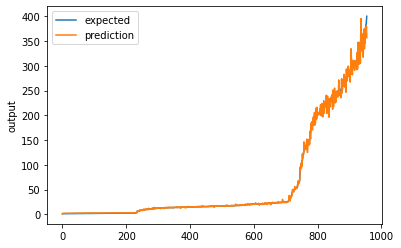

In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=x_NN.shape[1], activation='relu'))      # try changing 100 to 10
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])  #maybe remove accuracy because it = 0...

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=500)

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

#LSTM Model
Use Long Term Neural Network instead.

Records should be viewed as a sequence of 7 vectors, each with 5 dimensions

In [ ]:
df

,Open,High,Low,Close,Volume,Close_Output
0,-0.615054,-0.610991,-0.616485,-0.612011,2.276485,1.592667
1,-0.610333,-0.607308,-0.612373,-0.612053,1.987555,1.588667
2,-0.610882,-0.610366,-0.614536,-0.613355,0.346716,1.464000
3,-0.612273,-0.612282,-0.615650,-0.615276,-0.216617,1.280000
4,-0.614359,-0.614389,-0.617706,-0.617427,0.099373,1.074000
...,...,...,...,...,...,...
3186,1.419443,1.386986,1.435485,1.427087,0.577808,196.880005
3187,1.478894,1.506761,1.526074,1.539333,0.807120,207.630005
3188,1.568174,1.525211,1.552737,1.519285,0.710964,205.710007
3189,1.522491,1.484131,1.496735,1.488587,0.756190,202.770004


In [ ]:
print(x[1].shape)
print(y[1].shape)

(7, 5)
(1,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

Epoch 1/500
70/70 - 6s - loss: 10512.0645 - accuracy: 0.0000e+00 - val_loss: 8754.9590 - val_accuracy: 0.0000e+00 - 6s/epoch - 92ms/step
Epoch 2/500
70/70 - 2s - loss: 5363.4849 - accuracy: 0.0000e+00 - val_loss: 3675.2307 - val_accuracy: 0.0000e+00 - 2s/epoch - 29ms/step
Epoch 3/500
70/70 - 4s - loss: 1981.8523 - accuracy: 0.0000e+00 - val_loss: 1208.1328 - val_accuracy: 0.0000e+00 - 4s/epoch - 64ms/step
Epoch 4/500
70/70 - 6s - loss: 713.6285 - accuracy: 0.0000e+00 - val_loss: 504.6869 - val_accuracy: 0.0000e+00 - 6s/epoch - 81ms/step
Epoch 5/500
70/70 - 4s - loss: 336.6852 - accuracy: 0.0000e+00 - val_loss: 259.7364 - val_accuracy: 0.0000e+00 - 4s/epoch - 56ms/step
Epoch 6/500
70/70 - 2s - loss: 215.2831 - accuracy: 0.0000e+00 - val_loss: 157.4941 - val_accuracy: 0.0000e+00 - 2s/epoch - 28ms/step
Epoch 7/500
70/70 - 2s - loss: 156.7158 - accuracy: 0.0000e+00 - val_loss: 110.9448 - val_accuracy: 0.0000e+00 - 2s/epoch - 28ms/step
Epoch 8/500
70/70 - 3s - loss: 119.9558 - accuracy: 0.0

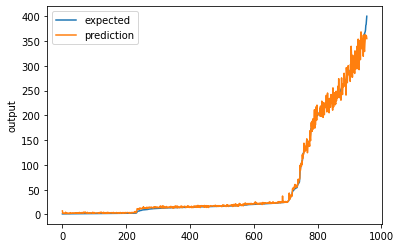

In [ ]:
model = Sequential()
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5)))
model.add(Dense(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])  #maybe remove accuracy because it = 0...

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=500)

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

#CNN Model
Convolutional Neural Network

Use Dense, convolution, max, dropout, and flatten layers to create the model.

Output can be viewed as a 1D Image of 7 pixels, each pixel with 5 channels, or as a 2D image of 7*5 = 35 pixels, each pixel with 1 channel.

In [102]:
#Visualize shapes before reshaping
print("x shape: " + str(x.shape))
print("y shape: " + str(y.shape))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

print("x_train shape: " + str(x_train.shape))
print("y_train shape: " + str(y_train.shape))
print("x_test shape: " + str(x_test.shape))
print("y_test shape: " + str(y_test.shape))

x shape: (3183, 7, 5)
y shape: (3183, 1)
x_train shape: (2228, 7, 5)
y_train shape: (2228, 1)
x_test shape: (955, 7, 5)
y_test shape: (955, 1)


In [103]:
#Reshape input to be a 4D Array of (number of samples, rows per sample, columns per sample, and number of channels)
#Note since we aren't using an RGB image, our channels is 1.
img_rows = 7
img_cols = 5

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))

x_train shape: (2228, 7, 5, 1)
x_test shape: (955, 7, 5, 1)


In [234]:
model = Sequential()
input_shape = (img_rows, img_cols, 1)

model.add(Conv2D(256, kernel_size=(4, 4), strides=(1, 1), padding='same',  #include padding because we got some goofy dimensions
                 activation='relu',
                 input_shape=input_shape))    #  in this case, input_shape = (img_rows, img_cols, 1)

In [235]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 7, 5, 256)         4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________


In [236]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.25)) 

In [237]:
model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1))

In [238]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 7, 5, 256)         4352      
                                                                 
 conv2d_55 (Conv2D)          (None, 5, 3, 64)          147520    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 2, 1, 64)         0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 2, 1, 64)          0         
                                                                 
 flatten_17 (Flatten)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               16512     
                                                     

In [239]:
# show not only log loss but also accuracy for each epoch using metrics=['accuracy']
from tensorflow.keras.optimizers import Adam
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

Epoch 1/200
9/9 - 2s - loss: 11877.1377 - accuracy: 0.0000e+00 - val_loss: 11471.7881 - val_accuracy: 0.0000e+00 - 2s/epoch - 200ms/step
Epoch 2/200
9/9 - 0s - loss: 7136.7866 - accuracy: 0.0000e+00 - val_loss: 1946.4259 - val_accuracy: 0.0000e+00 - 86ms/epoch - 10ms/step
Epoch 3/200
9/9 - 0s - loss: 1494.4904 - accuracy: 0.0000e+00 - val_loss: 897.8865 - val_accuracy: 0.0000e+00 - 94ms/epoch - 10ms/step
Epoch 4/200
9/9 - 0s - loss: 931.5327 - accuracy: 0.0000e+00 - val_loss: 1056.1384 - val_accuracy: 0.0000e+00 - 94ms/epoch - 10ms/step
Epoch 5/200
9/9 - 0s - loss: 946.6779 - accuracy: 0.0000e+00 - val_loss: 232.8727 - val_accuracy: 0.0000e+00 - 82ms/epoch - 9ms/step
Epoch 6/200
9/9 - 0s - loss: 715.5552 - accuracy: 0.0000e+00 - val_loss: 231.7778 - val_accuracy: 0.0000e+00 - 93ms/epoch - 10ms/step
Epoch 7/200
9/9 - 0s - loss: 627.6308 - accuracy: 0.0000e+00 - val_loss: 299.5977 - val_accuracy: 0.0000e+00 - 89ms/epoch - 10ms/step
Epoch 8/200
9/9 - 0s - loss: 601.2039 - accuracy: 0.0000

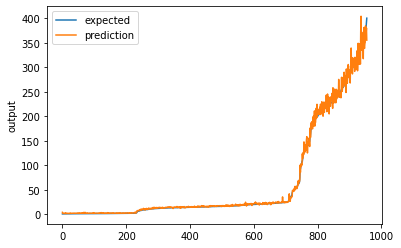

Elapsed time: 0:00:22.64


In [240]:
import time

start_time = time.time()

batch_size = 256

model.fit(x_train, y_train,     
          batch_size=batch_size,
          epochs=200,
          verbose=2,
          validation_data=(x_test, y_test))

elapsed_time = time.time() - start_time

##model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)
print("Elapsed time: {}".format(hms_string(elapsed_time)))

In [134]:
print(pred)

[[303.6691   ]
 [ 13.353323 ]
 [  8.872517 ]
 [  1.9291016]
 [ 21.634398 ]
 [  1.7921014]
 [  1.8360586]
 [ 14.335604 ]
 [  1.7034341]
 [288.59158  ]
 [241.49683  ]
 [237.98242  ]
 [  1.7369033]
 [346.97708  ]
 [ 21.659948 ]
 [ 13.75494  ]
 [ 17.236578 ]
 [ 13.475241 ]
 [  1.8573307]
 [  7.5544553]
 [230.28932  ]
 [200.65182  ]
 [  1.7208565]
 [  2.3479676]
 [ 20.840515 ]
 [  1.8010502]
 [  9.143413 ]
 [292.30865  ]
 [ 16.20877  ]
 [318.07178  ]
 [ 10.882114 ]
 [ 11.297227 ]
 [  1.8144077]
 [  1.7333544]
 [ 15.570618 ]
 [185.00684  ]
 [  1.7444651]
 [  1.8257972]
 [321.0395   ]
 [ 59.80988  ]
 [ 16.663578 ]
 [ 22.066347 ]
 [ 18.466698 ]
 [ 97.7322   ]
 [  1.6819471]
 [ 15.304576 ]
 [ 14.428585 ]
 [ 18.54329  ]
 [  1.8682203]
 [ 14.529461 ]
 [ 11.458304 ]
 [ 12.52636  ]
 [ 20.436579 ]
 [233.39069  ]
 [ 46.510906 ]
 [ 17.616941 ]
 [ 11.690437 ]
 [  1.7979965]
 [344.83554  ]
 [  1.7959872]
 [  1.6399873]
 [ 14.412493 ]
 [ 15.960297 ]
 [217.82849  ]
 [  1.8543751]
 [ 12.193315 ]
 [ 46.3023

In [81]:
score = model.evaluate(x_test, y_test, verbose=0)
score

[13660.87890625, 0.0]

In [82]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 13660.87890625
Test accuracy: 0.0


# Additional Features

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras.optimizers import SGD, Adam
from keras.activations import relu, sigmoid, tanh
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Define the hyperparameter search space
activations = [relu, sigmoid, tanh]
layers = [[64], [64, 32], [128, 64, 32]]
optimizers = [SGD(), Adam()]
kernels = [[32, (3,3)], [64, (3,3)], [64, (5,5)], [128, (5,5)]]
lstm_layers = [[32], [64], [32, 32], [64, 32]]

# Define a function to create the model with a given set of hyperparameters
def create_model(activation, layer_sizes, optimizer, kernel=None, lstm_layer_sizes=None):
    model = Sequential()
    if kernel:
        model.add(Conv2D(kernel[0], kernel_size=kernel[1], activation=activation, input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
    elif lstm_layer_sizes:
        if len(lstm_layer_sizes) == 1:
            model.add(LSTM(lstm_layer_sizes[0], input_shape=input_shape))
        else:
            model.add(LSTM(lstm_layer_sizes[0], input_shape=input_shape, return_sequences=True))
            for size in lstm_layer_sizes[1:-1]:
                model.add(LSTM(size, return_sequences=True))
            model.add(LSTM(lstm_layer_sizes[-1]))
    else:
        model.add(Flatten(input_shape=input_shape))
    for size in layer_sizes:
        model.add(Dense(size, activation=activation))
        model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Define a function to run the hyperparameter search
def run_experiment():
    best_rmse = float('inf')
    best_params = None
    for activation in activations:
        for layer_sizes in layers:
            for optimizer in optimizers:
                for kernel in kernels:
                    for lstm_layer_sizes in lstm_layers:
                        model = create_model(activation, layer_sizes, optimizer, kernel, lstm_layer_sizes)
                        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32, callbacks=[early_stopping], verbose=0)
                        y_pred = model.predict(X_test)
                        rmse = mean_squared_error(y_test, y_pred, squared=False)
                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_params = {'activation': activation.__name__, 'layer_sizes': layer_sizes, 'optimizer': optimizer.__class__.__name__, 'kernel': kernel, 'lstm_layer_sizes': lstm_layer_sizes}
    return best_params, best_rmse

# Run the hyperparameter search
best_params, best_rmse = run_experiment()

# Print the best hyperparameters and RMSE score
print('Best hyperparameters:', best_params)
print('
